In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import dagshub
import pickle
from loguru import logger
from pathlib import Path
from mlflow.models import infer_signature
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    roc_curve,
    RocCurveDisplay,
)
from src.config import DATA_DISK, CONFUSION_MATRIX_DIR, ROC_CURVE_DIR, MODELS_DIR

2025-03-02 01:54:20.363 | INFO     | src.config:<module>:11 - PROJ_ROOT path is: /home/minhquana/workspace/water_potability_prediction


In [2]:
model_path: Path = MODELS_DIR / "model.pkl"
cm_path: Path = CONFUSION_MATRIX_DIR / "confusion_matrix.png"
roc_path: Path = ROC_CURVE_DIR / "roc_curve.png"

dagshub.init(repo_owner="minhquana1906", repo_name="water_potability_prediction", mlflow=True)
mlflow.set_tracking_uri("https://dagshub.com/minhquana1906/water_potability_prediction.mlflow")
mlflow.set_experiment("Experiment 4")

Accessing as minhquana1906

Initialized MLflow to track repo "minhquana1906/water_potability_prediction"

Repository minhquana1906/water_potability_prediction initialized!

<Experiment: artifact_location='mlflow-artifacts:/4bca647ae31e4a728b50f5e7c2ab7eea', creation_time=1740852137024, experiment_id='2', last_update_time=1740852137024, lifecycle_stage='active', name='Experiment 4', tags={}>

In [3]:

def fill_missing_with_mean(df: pd.DataFrame) -> pd.DataFrame:
    return df.fillna(df.mean())

In [4]:
data = pd.read_csv(DATA_DISK)
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

train_processed_data = fill_missing_with_mean(train_data)
test_processed_data = fill_missing_with_mean(test_data)

X_train = train_processed_data.drop(columns=["Potability"], axis=1)
y_train = train_processed_data["Potability"]
X_test = test_processed_data.drop(columns=["Potability"], axis=1)
y_test = test_processed_data["Potability"]

In [5]:
model = RandomForestClassifier()

In [6]:
# Implement RandomizedSearchCV for hyperparameter tuning
param_dist = {
    "n_estimators": [50, 200, 500, 800, 1000, 1200],
    "max_depth": [None, 3, 9, 15, 30],
    "min_samples_split": [2, 8, 15, 100],
    "min_samples_leaf": [1, 2, 5],
}

search = RandomizedSearchCV(
    model,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42,
    scoring="accuracy",
)

2025-03-02 01:54:23.843 | INFO     | __main__:<module>:2 - Training Random Forest model with hyperparameter tuning...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=100, n_estimators=50; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=100, n_estimators=50; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=100, n_estimators=50; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=100, n_estimators=50; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=100, n_estimators=50; total time=   0.4s
[CV] END max_depth=15, min_samples_leaf=1, min_samples_split=8, n_estimators=500; total time=   3.5s
[CV] END max_depth=15, min_samples_leaf=1, min_samples_split=8, n_estimators=500; total time=   3.6s
[CV] END max_depth=15, min_samples_leaf=1, min_samples_split=8, n_estimators=500; total time=   3.5

/home/minhquana/anaconda3/envs/water_potability_prediction/lib/python3.9/site-packages/sklearn/metrics/_plot/roc_curve.py:189: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


2025-03-02 01:55:39.169 | INFO     | __main__:<module>:55 - Logging source code file to MLflow...
🏃 View run Random Forest Tuning at: https://dagshub.com/minhquana1906/water_potability_prediction.mlflow/#/experiments/2/runs/1f6367d382fa4902b8231e59c8b3d84b
🧪 View experiment at: https://dagshub.com/minhquana1906/water_potability_prediction.mlflow/#/experiments/2


NameError: name '__file__' is not defined

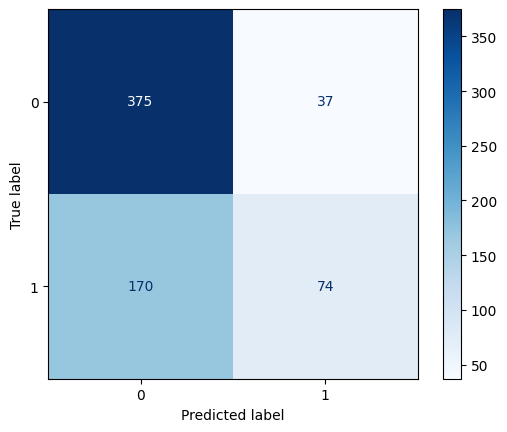

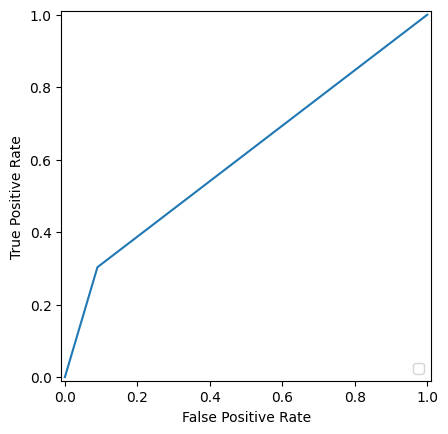

In [7]:
with mlflow.start_run(run_name=f"Random Forest Tuning") as parent_run:
    logger.info(f"Training Random Forest model with hyperparameter tuning...")
    search.fit(X_train, y_train)
    for i in range(len(search.cv_results_["params"])):
        with mlflow.start_run(run_name=f"Combination {i}", nested=True) as children_run:
            mlflow.log_params(search.cv_results_["params"][i])
            mlflow.log_metric("mean_test_score", search.cv_results_["mean_test_score"][i])

    logger.info(f"Best parameters: {search.best_params_}")
    logger.info("Logging best params to MLflow...")
    mlflow.log_params(search.best_params_)

    logger.info(f"Training model with parameters: {search.best_params_}")
    # model.set_params(**search.best_params_)
    model = search.best_estimator_
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    logger.info(f"Evaluating model...")
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    logger.info(f"Logging metrics to MLflow...")
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("f1 score", f1)

    # mlflow.sklearn.log_model(model, model_name)

    logger.info(f"Saving model to {model_path}...")
    pickle.dump(model, open(model_path, "wb"))

    logger.info(f"Logging model to MLflow...")
    signature = infer_signature(X_train, model.predict(X_train))
    mlflow.sklearn.log_model(model, "RandomForestClassifier", signature=signature)

    logger.info(f"Generating confusion matrix and ROC curve and logging to MLflow...")
    cm = confusion_matrix(y_test, y_pred)
    cm_display = ConfusionMatrixDisplay(cm).plot(
        cmap="Blues",
        values_format="d",
    )
    plt.savefig(cm_path)
    mlflow.log_artifact(cm_path)

    roc = roc_auc_score(y_test, y_pred)
    fpr, tpr = roc_curve(y_test, y_pred)[:2]
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    plt.savefig(roc_path)
    mlflow.log_artifact(roc_path)

    # logger.info(f"Logging source code file to MLflow...")
    # mlflow.log_artifact(__file__)

    logger.info(f"Logging dataset to MLflow...")
    train_df = mlflow.data.from_pandas(train_processed_data)
    test_df = mlflow.data.from_pandas(test_processed_data)
    mlflow.log_input(train_df, "train")
    mlflow.log_input(test_df, "test")

    logger.success(f"Experiment completed successfully!")
